In [1]:
import csv
import googletrans
import seaborn as sns
import matplotlib.pyplot as plt


from collections import Counter
from pandas import DataFrame
from random import sample

### Dataset Paths

In [2]:
TRAIN_ENG="data/train_en.csv"
TRAIN_TCN="data/train_tcn.csv"
DEV_ENG="data/dev_en.csv"
DEV_TCN="data/dev_tcn.csv"
TEST_TCN="data/test_tcn.csv"

### Data Denoise and Collection

Dataset contains very poor and inconsistent handling of double quotes. For the ENG datasets, the only real value of the double quote is to indicate 'inches' for measurements in certain contexts. Otherwise, double quotes have no real value and can be removed. The dataset is also not a true CSV, with inconsistent number of columns in the dataset. This problem is also present in the TCN dataset.

After manually analyzing the errors, here's how we can recover most of the broken data:

1. Replace all \" (backslash double quote) with a placeholder.

2. Remove all ", then recover all \"

3. Don't use Python CSV reader, perform manual string splits by commas. Use rfind to find last comma, which indicates the start of the category label, except for the "Toys, Games & Collectibles" category. We handle that as a special case.

4. If line does not have commas, it will be rolled over (prepended) to the next line (this is because actual data is broken over multiple lines, most likely because user had a newline in the input which team did not sanitize)

In [3]:
hardcoded_eng_categories = ["Hobbies & Stationery",
                            "Health & Personal Care",
                            "Mobile Accessories",
                            "Home & Living",
                            "Women's Apparel",
                            "Women Shoes",
                            "Babies & Kids",
                            "Women Accessories",
                            "Toys, Games & Collectibles",
                            "Groceries",
                            "Motors",
                            "Makeup & Fragrances",
                            "Women's Bags",
                            "Men's Apparel",
                            "Pet Care",
                            "Men's Bags & Accessories",
                            "Sports & Travel",
                            "Men Shoes",
                            "Gaming",
                            "Laptops & Computers",
                            "Home Entertainment",
                            "Mobiles & Gadgets",
                            "Cameras",
                            "Home Appliances",
                            "Consumer Electronics",
                            "Digital Goods & Vouchers"]
hardcoded_eng_categories = set(hardcoded_eng_categories)

In [4]:
hardcoded_tcn_categories = ["Health & Beauty",
                            "Game Kingdom",
                            "Life & Entertainment",
                            "Mother & Baby",
                            "Men's Apparel",
                            "Women's Apparel",
                            "Women Bags",
                            "Women Shoes",
                            "Home & Living",
                            "Everything Else",
                            "Hardware & 3C",
                            "Men's Bags& Accessories",
                            "Sports & Outdoors",
                            "Helpbuy",
                            "Men Shoes",
                            "Books",
                            "Motors",
                            "Home Electronic",
                            "Food & Beverages",
                            "Mobile & Gadgets",
                            "Women Accessories",
                            "Pets",
                            "Tickets & Services"]
hardcoded_tcn_categories = set(hardcoded_tcn_categories)

In [5]:
def get_eng_data(filename, categories=hardcoded_eng_categories, LIMIT=-1):

    rows = []
    
    with open(filename) as f:
        
        count = 0
        
        # Ignore header
        next(f)
        
        # Setup rollover
        prev = ""
        
        # Iterate over lines
        for line in f:
            line = prev + " " + line
            line = line.replace('\\"', "<XXX>")
            line = line.replace('"', '')
            line = line.replace("<XXX>", '"').strip()
            
            tokens = line.split(",")
            if len(tokens) == 1: # no commas
                prev = line
                continue
                            
            category = tokens[-1] # Category is the last token
            
            # Check against list of categories so we don't admit nonsense
            if category not in categories:
                            
                # Handle special case            
                if "Games & Collectibles" in category:
                    category = "{}, {}".format(tokens[-2].strip(), tokens[-1].strip())
                    rows.append((",".join(tokens[:-2]), category))
                else:
                    continue                
            else:
                rows.append((",".join(tokens[:-1]), category))
                
            prev = "" # Clear out rollover
                
            count += 1
            
            # Early terminate if specified
            if LIMIT >= 0 and count >= LIMIT:
                break
            
    return rows
    

def get_tcn_data(filename, categories=hardcoded_tcn_categories, LIMIT=-1):
    
    rows = []
    
    with open(filename) as f:
        
        count = 0
        
        # Ignore header
        next(f)
        
        # Setup rollover
        prev = ""
        
        # Iterate over lines
        for line in f:
            
            line = prev + line
            comma_index = line.rfind(",")
            if comma_index < 0:
                prev = line
                continue
                                
            category = line[comma_index + 1:].strip() # Category is the last token
            
            
            # Check against list of categories so we don't admit nonsense
            if category not in categories:
                continue

            rows.append((line[:comma_index].strip(), category))
                
            prev = "" # Clear out rollover
                
            count += 1
            
            # Early terminate if specified
            if LIMIT >= 0 and count >= LIMIT:
                break
            
    return rows


def get_generic_data(filename, LIMIT=-1):
    
    rows = []
    
    with open(filename) as f:
        
        count = 0
        
        # Ignore header
        next(f)
        
        # Iterate over lines
        for line in f:
            
            rows.append((line.strip(), "private"))
            count += 1
            
            # Early terminate if specified
            if LIMIT >= 0 and count >= LIMIT:
                break
            
    return rows


In [6]:
# Define a sample size for viewing sample parsing results
SAMPLE_SIZE=500

In [7]:
train_eng_data = get_eng_data(TRAIN_ENG)
for ex in sample(train_eng_data, SAMPLE_SIZE):
    print(ex[0])

COLORED  GLASS
2
Touch Screen Biometrics Fingerprint Scanner Time & Attendance Recorder Time Recorder Bundy Clock
Men's Poloshirt Cotton Hanicom Quality
Mini korean bag #763
michael kors ladies eva slipper
COD Plain Ryle Terno
INTEX 147cm*33cm pool
Hair Fiber (Instant hair)
Coach Zip Wrist Wallet *FROM US OUTLET*
Pampered Pooch Cologne 125ML
Basic Side Slit Dress
Authentic Etude House Moistfull Collagen Deep Cream
Saint Roche Ultra Premium All Natural Detangling and Dematting Spray for Dogs 318ml
Suave Rose Oil Infusion Volumizing Shampoo 12.6 FL. OZ.
PISTON RING 55MM 1.0 | M3 | BEAT
AT-6030 30mm Aluminum Light Table Vice Vanker DIY Tool
Peppermint Essential Oil
ORIG Engineering Mechanics & Physics Formulas Besavilla
invisible case w stand y7 pro 2019 y7 2019 y7pro 2019
SLIDER                     UNIVERSAL
Japan Key Coffee Drip On
SC-00122 - Scented Candles (Silver) - Small (White Peach)
♥️48pcs♥️250ml amber bottle trigger spray
PRELOVED LeapFrog My Pal Violet
Solo Shirt / Couple or Fa

In [8]:
train_tcn_data = get_tcn_data(TRAIN_TCN)
for ex in sample(train_tcn_data, SAMPLE_SIZE):
    print(ex[0])

台灣公司貨 REEBOK ZPUMP FUSION x STASH 彩色 塗鴉 V63198 運動休閒跑鞋 現貨10.5
冷變色水杯女創意便攜個性可愛潮流簡約家用小清新辦公室玻璃杯子
現貨到‼️不會掉的集中爆乳蕾絲後扣式無鋼圈平口內衣
汽車BMW門板縫隙儀表臺內飾出風口裝飾條線免貼卡式車門內裝飾線
超好吃的~2包250凱莎粒 巧克力
☼BVLGARI寶格麗雙圈蛇手鐲以令人沉醉的絕妙設計捕捉Serpenti手鐲的魅力、誘惑和迷人的性感61211621
老式支架頭窗簾桿支架天花板配件多功能吊頂直軌支架座固定腳大號
現貨促銷科士威～草本洗髮精 - 適合乾燥、受損髮質
汽車搖頭擺件 彩色搖擺氣球 創意可愛個性車載擺件 告白氣球 小清新擺件 時尚女神款裝飾品 彈簧搖擺氣球 裝飾卡通底座搖擺
原厂MASERATI 玛莎拉蒂手表R8871612015 海神蓝面计时手表
(現貨)芭比生日透明蛋糕盒4泡沫底托68底板10托盤四六八寸十二凸盤底子
NIKE AIR PRESTO PRM 女子運動鞋 878071-002
葉媽咪下標
Giorgio Armani 亞曼尼 訂製光智慧保濕彈潤精華 5ml (有盒有中標)
手工鈎織向日葵小猪可當包包掛件用成品
╋清倉價╋春季女士韓版打底衫百搭短款小背心大碼內搭上衣抹胸薄款蕾絲吊帶
預購～寬鬆韓版哈倫小腳褲
買2送1/現貨/泊泉雅男士控油透潤爽膚水補水保濕收縮毛孔提亮膚色舒緩肌膚直銷熹熹
兒童玩具收納架置物架多層收納神器幼兒園儲物柜寶寶玩具整理書架
代購 專櫃 正品 YSL聖羅蘭 新款 F26600 女士牛皮金屬字母Logo流蘇翻蓋包 簡潔 高雅
瓷印象茶壺
(代購)Rakuten證件帶-基本-黑、紅 樂天桃猿
陽光8點兒童書包小學生PU書包2-3-4-5年級8-12歲女童雙肩背包
Miss Dior EAU DE PARFUM小香水
#樂#鑽石畫滿鑽貼鑽浮雕吉祥鹿走廊玄關客廳歐式十字繡新款鑽石繡 鑽量多配30%
日本代購 限定佳宜下標
特惠【官方直營】【隨機簽名版】 九國夜雪外傳 歸期原名說狐水阡墨古風贈明信片紫國古代言情小說暗花早春 潮范精品店
尤莉 媽媽禮服【CGL88223】媽媽裝/婚宴小禮服/晚宴服/旗袍/洋裝/夏姿風格禮服/晚宴包/披肩/出租/量身訂製
特惠可愛哈士奇毛絨玩具布娃娃玩偶二哈女孩床上睡覺抱枕公仔生日禮物
斌斌小店M43

In [9]:
dev_eng_data = get_generic_data(DEV_ENG)
for ex in sample(dev_eng_data, SAMPLE_SIZE):
    print(ex[0])

Crown Dog Tank - Puppy 100G Paul Pet Products
Roush - Stand Collar Open Button Design Brush Cap teee 【 715583 】
[Head Gear] Slow Iron Hook Easy Pack Fishing Special Accessories
Phyto Hair Flower Plant Shampoo (100Ml / 200Ml) [Paris D]
IFairies Chiffon Tops 【 45804 】
NATIVE JEFFERSON Cream Head Casual Shoes Lightweight Shoes Unisex 001006399NATIVE JEFFERSON
SWAROVSKI 925 Sterling Silver Bracelet E42
LeSportsac sweet letter Daily Tote Pack
KIKIKO Action Professional Sport Swimming Goggles (Blue)
Create Synthetic Life DVD
Parker Urban The Series Pink White Pen P0844870 / F
Augelute Rose Fleece Horn Button Hooded Warm Coat 50605
Asus Phone Case Zb551Kl Zc554Kl Ze554Kl Ze552Kl Ze520Kl Zb552Kl
Etude House Natural Moisturizing Lip Dew 10g
Christian Dior Fashion Thick Frame Sunglasses
Polka Dots Lotus Leaf word Short Tops
BMW M Power Body Stickers E30 E34 E36 E38 E39 E46 E60 e65 Yi xuan Boutique
Oversized Storage Net Bag 20 * 8Cm Mesh Debris Storage 【 Ae10120 】
Bottega Veneta BV NAPPA Classic 

In [10]:
dev_tcn_data = get_tcn_data(DEV_TCN, categories=set(["private"]))
for ex in sample(dev_tcn_data, SAMPLE_SIZE):
    print(ex[0])

TORY BURCH 可愛海軍風船錨圖騰草編樂福鞋
巴黎萊雅完美淨白淨白潔面露100ML【屈臣氏】
勇往直前2 DVD VOL-1
德國原裝進口 Online 花仙子多功能套筆組 57917 /組
P1232空間對策-日式折合曬衣架(角型32夾)
Apple iPhone 5 i Phone 5/5S 手機殼/iP5/手機殼/保護殼
【6879-0621】金属圆环挂脖修身露肩连身裙 洋装
以色列Red Sea紅海 K鉀離子測試組 R21435 海水測試組
樹德 A4-B209 桌上型資料櫃 1-5202A4-B209
LANCOME蘭蔻 超緊顏5D太空按摩霜75ml TESTER
Roger & Gallet 西班牙柑橘香水身体乳液 200ML RNG0420013
陽光康喜 鳳梨酵素+納豆x4盒
德一 卡賀方塊酥袋裝300G
摩拉多層膜運動太陽眼鏡 Swan-GRB MOLA SPORTS
拖鞋 可愛大蝴蝶結百搭拖鞋-3 艾爾莎【TSB8779】
冰雪奇緣 白雪森林 藍 卡通睡袋 台灣製 迪士尼
梅亚奶奶 乡村天然狗宠粮 1.81/6.35 kg
優力潔 泡泡糖新型針織專利浴巾(藍)
J II 雙箭頭小款尼龍後背包-6171
多功能觸摸自行車 單車 腳踏車前包s125
[芭蒂蘿絲]絲柏精油
【Hello Kitty】凱蒂貓後背書包-粉紅(KT-6653)
Bonjouracc 三角毛毡球 925银针 夹式 针式 耳环
Handscript手稿系列鋼筆*EF尖
神奇寶貝皮卡丘手機殼三星 S4 S5 S6 S7 EDGE PLUS S8 S8+ NOTE4 NOTE5 NOTE8
小叮噹的店- 調音器/節拍器 KORG TM-50 TM-60
alfastar 藍牙運動耳機 SH360B
日本JEJ Postmodern 置物收納籃 #10 2色可選
ASUS 手机壳 韩风 匹诺曹 ZE520KL ZE552KL ZE553KL ZE554KL ZD552KL Z00
時尚氣質清新實用髮帶 髮飾 髮箍306
展榮 19mm微笑長尾夾 BC070 24入 / 筒
多彩舒適棉素面百搭大尺碼POLO短衫_薰衣紫
BK-S1 BKS1 耳機配件組
女童裝 夏季洋裝 魔法Baby~k50319
Kingston 金士頓 DT106/64GB 隨身碟 DataTraveler 1

In [11]:
test_tcn_data = get_eng_data(TEST_TCN, categories=set(["public"]))
for ex in sample(test_tcn_data, SAMPLE_SIZE):
    print(ex[0])

PLATINUM 白金牌 CPA-60 簽字型墨筆 / 支
潔保 LV-22TS 黑全網高級座椅 S1-52010002
NEW BALANCE Fresh Foam 跑鞋 運動鞋 針織 深灰色 男鞋 MARISRB1 no324
頂級絲光舒柔涼感冰絲蓆系列
Phyto Derma朵蔓 頭皮淨化噴霧80ml
iFairies 耳環【45660】
RiTEK 錸德 52x CD-R 空白光碟片 X版 原廠50片裝
【HARIO】清新便利茶壺450ml CHF-45GG
日本KOSE Clear Turn Princess Veil 面膜 46片入
喬依 洋裝 背帶裙 吊帶裙 顯瘦 波點 短裙洋裝 【J54】
LONGCHAMP LE PLIAGE 系列長把折疊包(大型)-1899
免運 GEX 犬貓食品暖食器 39℃ S號粉紅色 暖食物
【蕾黛絲】順型靠過來D-F罩杯內衣(烏股白)
DOT聚点 ADIDAS CAMO BACKPACK 黑灰 迷彩 后背包 笔电包 小LOGO 运动背包 DM2899
前普利珠盤全組 4CW 4TE
【Kaiyi Music】鈴木小提琴Suzuki school violin piano accompaniment 2
英文簡約白色T恤
強尼拍賣~ GOOSPERY SAMSUNG Galaxy A5(2017) 布丁套 軟套 保護套 保護殼
SKECHERS GOWALK ALL DAY COMFORT 運動鞋 藍色 女鞋 14902NVMT no739
PLATINUM 白金牌 PGB-500 PLAISIR 日本原裝金屬筆桿鋼筆 / 支
《 CHL 》日本 MT 和紙膠帶 MTEX1P82 標誌
Muurla 噜噜米马克杯 珐琅杯 水杯 靠在一起 粉蓝 370ml
【破盤價】美克司 MAX NO.10 號釘書針 800小盒入 / 件
韓國APIEU四色遮瑕修飾彩盤 6g【UR8D】
咖啡烘焙師 Coffee Roaster 單人桌遊 繁體中文版 高雄龐奇桌遊 桌上遊戲商品
CRYSTAL BALL ( I AM A DOLL )
native 洞洞鞋 水藍色 小童 no557
ADIDAS 愛迪達 GYM FZ HOODY 連帽運動外套 女 AJ4821 Big-O SPORTS
NEW BALANCE REVLITE 深蓝色 袜套

[芭蒂蘿絲]小樹手作石 皂章
OSIS黑旋風定型噴霧100ml
樹德 SC-306M SC 3排門多功能置物櫃
網面透氣楔型涼鞋拖鞋★ifairies【47325】
荷蘭 Pluggerz 成人 兒童 游泳耳塞 - 男孩
頂尖航空特技展DVD
UA Ignite V Slides 運動拖鞋 男女 二款任選
【G13080202】糖果色矽膠零錢包 馬卡龍色零錢包 果凍矽膠包
FREE!男子游泳部手機殼OPPO R9 R9S R11 R11S PLUS F1 F1S A39 A57 A77
台灣製雙人5x6尺透氣床墊 魔法baby~u3114


### Category Analysis

Brief look at the distribution of categories for products. Note that categories were only provided for the initial two training ENG and TCN datasets. The new dev datasets and the test datasets effectively have no category labels, so YMMV.

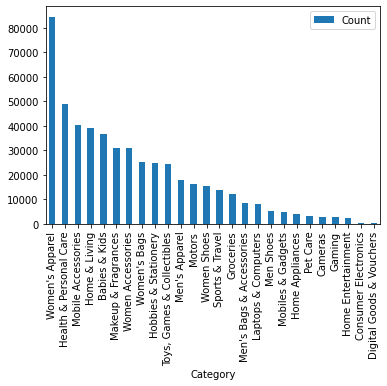

In [12]:
# Training English Categories
train_eng_categories = Counter(list(zip(*train_eng_data))[1])
train_eng_categories_df = DataFrame(sorted(train_eng_categories.items(), key=lambda x: x[1], reverse=True), columns=["Category", "Count"])
train_eng_categories_df.plot(kind="bar", x="Category")

plt.show()

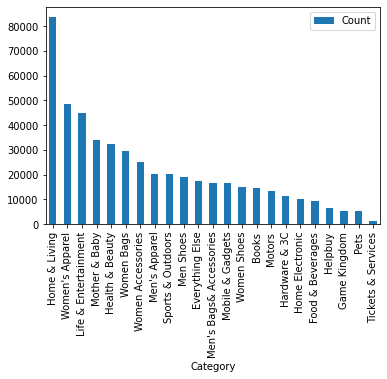

In [13]:
# Training Chinese Categories
train_tcn_categories = Counter(list(zip(*train_tcn_data))[1])
train_tcn_categories_df = DataFrame(sorted(train_tcn_categories.items(), key=lambda x: x[1], reverse=True), columns=["Category", "Count"])
train_tcn_categories_df.plot(kind="bar", x="Category")

plt.show()